In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from torch_geometric.data import download_url, extract_zip
import tqdm.notebook as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem

In [155]:
HERE = Path(".")
ROOT = Path("..")

# Load attribution data

In [2]:
from dataclasses import dataclass


@dataclass(frozen=True)
class FileArtifact:
    url: str
    path: Path
    force_download: bool = False

    def __post_init__(self):
        if self.path.exists() and not self.force_download:
            print(f"Using cached file '{self.path}'")
            return
        if not self.path.parent.exists():
            print(f"Creating directory '{self.path.parent}'")
            self.path.parent.mkdir(parents=True)
        print(f"Downloading file from '{self.url}' to '{self.path}'")
        download_url(self.url, self.path.parent, filename=self.file.name, log=False)

    def __repr__(self) -> str:
        return f"File from '{self.url}' is at path '{self.path}'"

    def __str__(self) -> str:
        return f"{self.path}"


@dataclass(frozen=True)
class ZipArtifact:
    url: str
    extract_at: Path
    expected_content: list[str]
    remove_zip: bool = False

    def __post_init__(self):
        if not self.extract_at.exists():
            print(f"Creating directory '{self.extract_at}'")
            self.extract_at.mkdir(parents=True)
        expected_content_exists = all(
            (self.extract_at / name).exists() for name in self.expected_content
        )
        if expected_content_exists:
            print(
                f"Using cached files from '{self.url}' extracted to '{self.extract_at}'"
            )
            return
        print(f"Downloading zip file from '{self.url}' to '{self.extract_at}'")
        path_to_zip = download_url(self.url, self.extract_at.parent, log=False)
        extract_zip(path_to_zip, self.extract_at, log=False)
        expected_content = set(self.expected_content)
        for new_file in self.extract_at.iterdir():
            if new_file.name in expected_content:
                expected_content.remove(new_file.name)
                continue
            print(f"Warning: got unexpected file '{new_file}'")
        if expected_content:
            print(f"Warning: missing expected files {expected_content}")
        if self.remove_zip:
            Path(path_to_zip).unlink()

    @property
    def path(self):
        return self.extract_at

    @property
    def contents(self) -> list[Path]:
        return [self.extract_at / name for name in self.expected_content]

In [3]:
residue_atom_index_artifact = ZipArtifact(
    "https://www.dropbox.com/scl/fi/cj2801jszmj73cmhklycx/residue_atom_index.zip?rlkey=i5qzddjcb4jcbao19h6jgfx00&st=go9ujwsg&dl=1",
    ROOT / "data" / "processed",
    expected_content=["residue_atom_index"],
)

mask_pl_edge_residue_results_artifact = ZipArtifact(
    "https://www.dropbox.com/scl/fi/2vt532fkofgdth2ae6c19/mask_pl_edges_at_residue.zip?rlkey=1z14ykkh8fn5lvwafc17b2gef&st=zqe0osr0&dl=1",
    ROOT / "data" / "crocodoc",
    expected_content=["mask_pl_edges_at_residue"],
)

Using cached files from 'https://www.dropbox.com/scl/fi/cj2801jszmj73cmhklycx/residue_atom_index.zip?rlkey=i5qzddjcb4jcbao19h6jgfx00&st=go9ujwsg&dl=1' extracted to '../data/processed'
Using cached files from 'https://www.dropbox.com/scl/fi/2vt532fkofgdth2ae6c19/mask_pl_edges_at_residue.zip?rlkey=1z14ykkh8fn5lvwafc17b2gef&st=zqe0osr0&dl=1' extracted to '../data/crocodoc'


In [4]:
# TODO
# - add PLIP artifact
# - add kinodata 3D raw and processed artifact?

## Data loading 1: crocodoc output data pl edge masking at residues

In [5]:
mask_pl_edge_residue_result = mask_pl_edge_residue_results_artifact.contents[0]

In [6]:
ref_dfs = []
attr_dfs = []
all_files = list(mask_pl_edge_residue_result.glob("*.csv"))
for csv_file in tqdm.tqdm(all_files):
    if "None" in csv_file.name:
        continue
    df = pd.read_csv(csv_file)
    if "cgnn3d" in csv_file.name:
        model = "CGNN-3D"
    elif "cgnn" in csv_file.name:
        model = "CGNN"
    else:
        model = None
    df["model"] = model
    if "reference" in csv_file.stem:
        ref_dfs.append(df)
        continue
    attr_dfs.append(df)

  0%|          | 0/945 [00:00<?, ?it/s]

In [7]:
attr_df = pd.concat(attr_dfs, axis=0)
ref = pd.concat(ref_dfs, axis=0)

attr_df = pd.merge(
    attr_df,
    ref[["chembl_activity_id", "reference_pred", "target", "model"]],
    on=["chembl_activity_id", "model"],
    how="left",
)

attr_df["delta"] = attr_df["reference_pred"] - attr_df["masked_pred"]

### Sanity check deltas for cgnn are close to zero

In [8]:
cgnn3d_only = attr_df[attr_df["model"] == "CGNN-3D"]
cgnn_only = attr_df[attr_df["model"] == "CGNN"]

## Data loading 2
- residue atom index (ie Map[ident, Map[residue id, pocket atom index of atoms in that residue]])
- Kinodata3D pytorch geometric data objects
- Kinodata3D underlying rdkit mols

In [9]:
from kinodata.data import KinodataDocked
from kinodata.data.dataset import _DATA
from pathlib import Path
from kinodata.transform import TransformToComplexGraph
import multiprocessing as mp
import json
from rdkit import Chem
from rdkit.Chem import Draw
import random


RESIDUE_ATOM_INDEX = residue_atom_index_artifact.contents[0]

to_cplx = TransformToComplexGraph()


def get_ident(file: Path):
    ident = int(file.stem.split("_")[-1])
    return ident


def load_single_index(file: Path):
    with open(file, "r") as f:
        try:
            dictionary = json.load(f)
        except json.decoder.JSONDecodeError:
            dictionary = None
    ident = int(file.stem.split("_")[-1])
    return (ident, dictionary)


def load_residue_atom_index(idents, parallelize=False):
    files = list(RESIDUE_ATOM_INDEX.iterdir())
    files = [file for file in files if get_ident(file) in idents]
    assert len(files) == len(idents)
    progressing_iterable = tqdm.tqdm(files, desc="Loading residue atom index...")
    if parallelize:
        with mp.Pool() as pool:
            tuples = pool.map(load_single_index, progressing_iterable)
    else:
        tuples = [load_single_index(f) for f in progressing_iterable]
    return dict(tuples)

In [10]:
dataset = KinodataDocked()

In [11]:
data_by_ident = {data.ident.item(): data for data in dataset}

In [12]:
mol_source_df = dataset.df

Reading data frame from /home/michael/Code/kinodata-3D-affinity-prediction/data/raw/kinodata_docked_v2.sdf.gz...
Deduping data frame (current size: 121913)...
119713 complexes remain after deduplication.
Checking for missing pocket mol2 files...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3244/3244 [00:00<00:00, 45056.14it/s]


Adding pocket sequences...
(119713, 25)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119713/119713 [00:00<00:00, 2923696.51it/s]


Exiting with 3552 cached sequences.
(119713, 26)


In [13]:
mol_source_df.columns

Index(['docking.posit_probability', 'docking.chemgauss_score',
       'activities.activity_id', 'assays.chembl_id',
       'target_dictionary.chembl_id', 'molecule_dictionary.chembl_id',
       'molecule_dictionary.max_phase', 'activities.standard_type',
       'activities.standard_units', 'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID', 'similar.klifs_structure_id',
       'similar.fp_similarity', 'ID', 'activities.standard_value',
       'docking.predicted_rmsd', 'molecule', 'pocket_mol2_file', 'ident',
       'structure.pocket_sequence'],
      dtype='object')

In [14]:
mols_by_ident = mol_source_df.set_index("ident")

In [15]:
mol_source_df["activities.activity_id"] = mol_source_df[
    "activities.activity_id"
].astype(int)

In [16]:
mols_by_chembl_id = mol_source_df.set_index("activities.activity_id")

## Data analysis 1: single complex delta analysis

Select a single complex and make select the data that corresponds to that complex.

In [153]:
import random

# set chembl activity id here, ...
# choice = 2390222
# choice = 3559317
choice = None#626043#None

if choice:
    subs = cgnn3d_only[cgnn3d_only["chembl_activity_id"] == choice]
    ident = subs["ident"].iloc[0]
    chembl_activity_id = choice
# or pick a random one
else:
    ident, index = random.choice(list(cgnn3d_only.groupby("ident").groups.items()))
    ra = load_residue_atom_index([ident])[ident]
    ra = {int(k): v for k, v in ra.items()}
    subs = cgnn3d_only.loc[index]
    chembl_activity_id = subs["chembl_activity_id"].iloc[0]
assert subs["chembl_activity_id"].nunique() == 1
assert subs["ident"].nunique() == 1

klifs_id = subs["klifs_structure_id"].unique()[0]
print(f"idents: chembl={chembl_activity_id} kinodata={ident} klifs={klifs_id}")

Loading residue atom index...:   0%|          | 0/1 [00:00<?, ?it/s]

idents: chembl=3442657 kinodata=19283 klifs=983


In [157]:
from kinodata.data.io.read_klifs_mol2 import read_klifs_mol2

pocket_file = ROOT / Path(f"data/raw/mol2/pocket/{klifs_id}_pocket.mol2")
pocket_file.exists()
mol2_meta = read_klifs_mol2(pocket_file, with_bonds=False)
mol2_meta = mol2_meta[["residue.subst_id", "residue.subst_name"]].drop_duplicates()
mask_to_weird = dict(zip(sorted(subs['masked_residue'].unique()), sorted(mol2_meta['residue.subst_name'].str[3:].astype(int))))
subs["residue.subst_id"] = subs["masked_residue"].apply(lambda x: mask_to_weird[x])
subs_with_mol2 = pd.merge(subs, mol2_meta, on="residue.subst_id", how="left")

In [158]:
subs_with_mol2.set_index('masked_residue').loc[28]

ident                    19283
chembl_activity_id     3442657
klifs_structure_id         983
masked_pred            7.37287
masked_resname             MET
masked_res_letter            M
model                  CGNN-3D
reference_pred         7.37287
target                6.309804
delta                      0.0
residue.subst_id           314
residue.subst_name        <NA>
Name: 28, dtype: object

#### Plot 

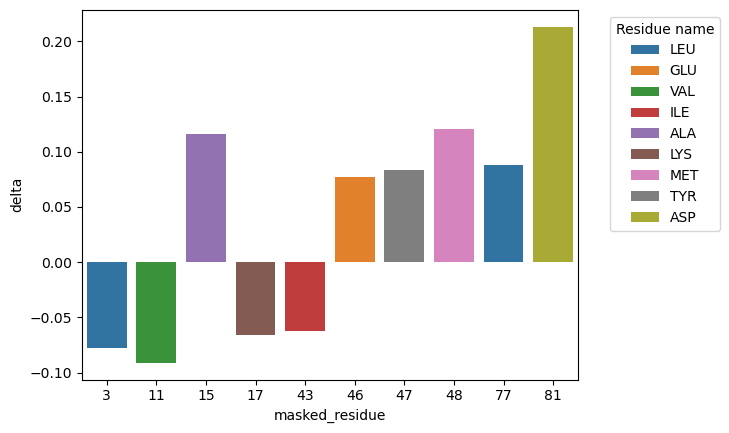

In [159]:
ax = sns.barplot(subs[subs.delta.abs() > .05], 
    x="masked_residue",
    y="delta",
    hue="masked_resname", dodge=False)


sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1), title="Residue name")

<AxesSubplot: xlabel='delta', ylabel='Density'>

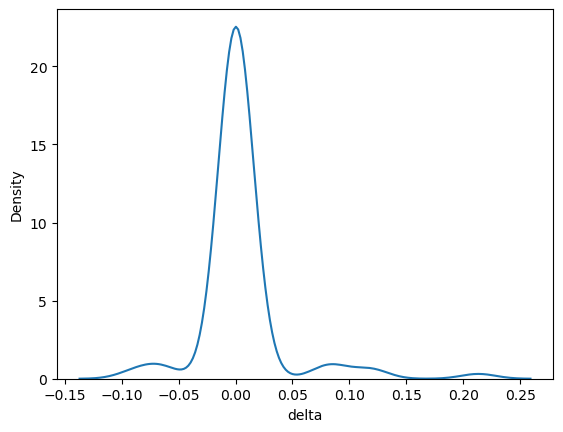

In [160]:
sns.kdeplot(subs_with_mol2, x='delta')

In [161]:
# get diverging color map
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=-1, vmax=1)
cmap = cm.get_cmap("bwr")
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)


def map_to_hex(val):
    max_val = subs['delta'].abs().max()
    rgba = cmapper.to_rgba(val / max_val)
    hex_color = f"#{''.join(f'{int(255 * x):02x}' for x in rgba[:3])}"
    return hex_color

subs_with_mol2["colorcode"] = subs_with_mol2["delta"].apply(map_to_hex)

In [162]:
import requests as req


for struc in 'ligand protein'.split():
    resp = req.get(f'https://klifs.net/api/structure_get_{struc}?structure_ID={klifs_id}')   
    with open(Path.home() / f"{struc}.mol2", 'wb') as f:
        f.write(resp.content)

In [163]:
!mv ~/ligand.mol2 ~/template_ligand.mol2

In [164]:
Chem.MolToMolFile(mols_by_chembl_id.loc[chembl_activity_id, 'molecule'], "/home/michael/ligand.mol")

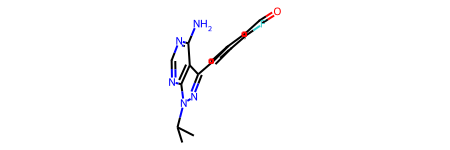

In [165]:
mols_by_chembl_id.loc[chembl_activity_id, 'molecule']

In [166]:
subs_with_mol2

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta,residue.subst_id,residue.subst_name,colorcode
0,19283,3442657,983,31,7.372864,LEU,L,CGNN-3D,7.37287,6.309804,0.000006,317,<NA>,#fffefe
1,19283,3442657,983,29,7.372868,LYS,K,CGNN-3D,7.37287,6.309804,0.000002,315,<NA>,#fffefe
2,19283,3442657,983,82,7.372869,PHE,F,CGNN-3D,7.37287,6.309804,0.000001,405,<NA>,#fffefe
3,19283,3442657,983,76,7.372864,ILE,I,CGNN-3D,7.37287,6.309804,0.000006,392,<NA>,#fffefe
4,19283,3442657,983,50,7.372864,LYS,K,CGNN-3D,7.37287,6.309804,0.000006,343,<NA>,#fffefe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,19283,3442657,983,75,7.372865,ASN,N,CGNN-3D,7.37287,6.309804,0.000005,391,<NA>,#fffefe
81,19283,3442657,983,41,7.372868,VAL,V,CGNN-3D,7.37287,6.309804,0.000002,328,<NA>,#fffefe
82,19283,3442657,983,70,7.372864,ASP,D,CGNN-3D,7.37287,6.309804,0.000006,386,<NA>,#fffefe
83,19283,3442657,983,37,7.372867,GLN,Q,CGNN-3D,7.37287,6.309804,0.000003,324,<NA>,#fffefe


In [167]:
with open(Path.home() / 'colors.cxc', 'w') as f:
    f.write('\n'.join([f'color :{ident} {c}' for c, ident in subs_with_mol2[['colorcode', 'residue.subst_id']].values]))

with open(Path.home() / 'viz.cxc', 'w') as f:
    f.write("""close session
open ~/protein.mol2
show surface
color grey
transparency 90 target s
open colors.cxc
open ~/template_ligand.mol2
open ~/ligand.mol
hb intraModel f reveal t twoColors t showDist t
hide surface
lighting depthCue t depthCueStart .3 depthCueEnd .9
graphics silhouettes true
set bgColor black""")